# **Challenge 3 - Neural Networks**
* Sahil Gill, Luke Ingram
* MATH 318 - Winter 2023

In [15]:
import cv2 
import tensorflow as tf
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import os
import itertools

## **Section 1 - Why Neural Nets?**

From the previous challenge, we can conclude that classifying these images is difficult. Despite our best attempts at expanding the K-Nearest-Neighbors algorithm, our model's accuracy was is not what's desired from a classifier. So, once again, we try a more sophisticated approach. 

Which brings us to Neural Networks. Neural networks are complex, but flexible, and have soared in popularity over the last 10-15 years. One specific type of Neural Net, the **Convolutionary Neural Network** designed for image processing, is what we will be using to tackle the challenge of trash classification. 


## **Section 2 - The Architecture**

The basic structure of a CNN is as follows: 

1. Input layers 
2. Convolutionary & Pooling Layers
3. Fully Connected Feature detectors 
4. Output layers

where input layers receive information as input, covnvolutionary layers run fitted kernels across the images to generate in-place features, these features are fed to pooling layers, which encode the "in-place" features generated by convolutionary layers into higher level features. Then finally the fully connected portion performs the highest level feature detection, followed by a classification by the output layer. 

The model we will use for trash classification will follow a similar structure.


### **Section 2.1 - MobileNetV2**

The network we'll be using is Google's MobileNetV2. a general purpose image classifier used in many applications. These applications range from object detection, facial recognition, to landmark recognition. This CNN was designed to meet the same accuracy you can see in VGG16 & VGG19, while training faster & running lighter.

The main difference between MobileNetV2 and the other popular image classifying CNNs is its use of *Depthwise convolutions*. 

Depthwise convolutions speed up both forward and backward propagation time by combining process of performing convolutions all three channels of an image into one convolution. Thus greatly reducing the number of matrix multiplications performed during execution. 

See below for a visualization of the *Depthwise Convolution*:

![](images/conv.png)

MobileNetV2's generality & efficiency makes it a fantastic candidate for out classification problem. 

### **Section 2.2 - Transfer Learning**

However, at full size, MobileNetV2 boasts a whopping 3.4 million parameters, typically outputting around 1000 different possible classes. A network like this would take an extreme amount of resources to train & validate, besides, in our task we only need to classify 6 different classes!

Using a technique called transfer learning, we can utilize the intelligent & effective convolutionary, pooling, & feature encoder layers of a general purpose network, such as MobileNetV2. We can take a pre-trained segment of the general-purpose network add our own final & output layers to specialize the general model to fit our specific task. 

Transfer Learning Visualization:

![](images/transfer_learning_general.png)

## **Section 3 - MobileNetV2 in Action**

Now it's time to put this into action. 

Before we begin, we need to load & normalize our data.

In [16]:
TARGET_NAMES =["Glass","Paper","Cardboard","Plastic","Metal","Trash"]

#Load data 
dirName = "../src/data/archive/zero-indexed-files.txt"
imgPath = "../src/data/archive/Garbage_classification/load/"

df = pd.read_csv(dirName,sep=' ')

df['image'] = imgPath + df['image'].astype(str)
df['image'] = df['image'].apply(lambda x: cv2.resize(cv2.imread(x),(224,224)))
print(df.head()) #DEBUG

train_X,test_X,train_Y,test_Y = train_test_split(df['image'],df['class'],
                                                 test_size=0.20,random_state=42,stratify=df['class'])


train_X,val_X,train_Y,val_Y = train_test_split(train_X,train_Y,
                                               test_size=0.20,random_state=42,stratify=train_Y)

# Normalize data 
train_X = train_X/255.0 
test_X = test_X/255.0
val_X = val_X/255.0

                                               image  class
0  [[[176, 189, 191], [177, 190, 192], [178, 191,...      0
1  [[[154, 167, 182], [151, 164, 180], [152, 165,...      0
2  [[[159, 171, 183], [157, 169, 181], [158, 170,...      0
3  [[[142, 154, 168], [142, 154, 168], [139, 151,...      0
4  [[[165, 177, 189], [165, 177, 189], [166, 178,...      0


### **Section 3.1 - Initializing MobileNetV2**

Keras provides us with an implementation of the MobileNetV2 network, we only have to specify the hyperparameters as follows: 

In [17]:
#Fetch network from keras, & define custom params. 
# This is a pre-trained model,but we remove the last layer 
# & train it ourselves to fit out problem
mobile_layer = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape = (224,224,3), # our images are in the shape
    alpha = 1.0, # using default input width
    include_top = False, #include fully-connected input layer
    weights = 'imagenet', # Default weights
    input_tensor = None, # using default input tensor structure
    pooling = None, # not using this feature
    classes = 1000, # default for MobileNet
    classifier_activation = 'softmax' #specify activation function of output layer
)   

# Make sure existing layers (convolutionary & pooling) remain untouched
mobile_layer.trainable = False

**Section 3.2 - Customized Output Layers**

TODO: Explain the transfer learning step & why we are using this many layers

In [18]:
model = tf.keras.models.Sequential()


model.add(tf.keras.Input(shape=(224,224,3))) # add our input layer
model.add(mobile_layer)# attach the pretrained portion of the model


# add our custom layers
model.add(tf.keras.layers.GlobalAvgPool2D()) # add an additional pooling layer
model.add(tf.keras.layers.Dense(6,activation='softmax')) # add softmax output layer

# Compile final model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam', # adam optimizer for Stochastic Gradient Descent
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


Without our top layers, out models at about 2.2 million untrainable (pre-trained) parameters, and 7686 trainable ones. The trainable parameters come from the Global average Pooling 2D layer along with the dense output layer. These are the parameters we will be training to optimize our model to our specific dataset. 

### **Section 3.3 - Training the Model**

Now it's time to fit the trainable parameters of our model. We will approach this using 30 epochs of stochastic gradient descent using the adam optimizer. Stochastic Gradient Descent is a standard & reliable training method, while 30 epochs is an arbitrary hyperparameter that provided decent results. 

Note: *with all forms of gradient descent using to high of an epoch number can result in overtraining. So with out limited size dataset, keeping the number of epochs on the lower side will help us avoid that overtraining issue.*

Epoch 1/30
51/51 [==============================] - 10s 179ms/step - loss: 1.2236 - accuracy: 0.5204 - val_loss: 0.7692 - val_accuracy: 0.6864
Epoch 2/30
51/51 [==============================] - 9s 173ms/step - loss: 0.6961 - accuracy: 0.7432 - val_loss: 0.6441 - val_accuracy: 0.7531
Epoch 3/30
51/51 [==============================] - 9s 173ms/step - loss: 0.5701 - accuracy: 0.8001 - val_loss: 0.5650 - val_accuracy: 0.7852
Epoch 4/30
51/51 [==============================] - 9s 174ms/step - loss: 0.4804 - accuracy: 0.8434 - val_loss: 0.5251 - val_accuracy: 0.8123
Epoch 5/30
51/51 [==============================] - 9s 173ms/step - loss: 0.4228 - accuracy: 0.8558 - val_loss: 0.5018 - val_accuracy: 0.8272
Epoch 6/30
51/51 [==============================] - 9s 173ms/step - loss: 0.3796 - accuracy: 0.8812 - val_loss: 0.4757 - val_accuracy: 0.8321
Epoch 7/30
51/51 [==============================] - 9s 173ms/step - loss: 0.3378 - accuracy: 0.8960 - val_loss: 0.4718 - val_accuracy: 0.8247
Epoch

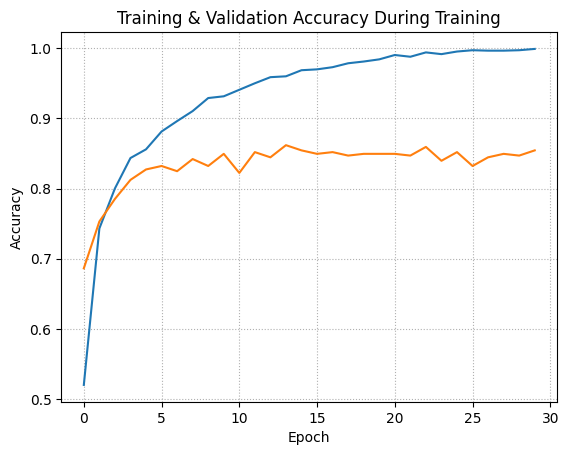

In [19]:
# Convert to float for tensor conversion 
train_X = np.asarray(list(train_X),dtype='float32')
test_X = np.asarray(list(test_X),dtype='float32')
val_X = np.asarray(list(val_X),dtype='float32')


training_history = model.fit(train_X,train_Y,epochs = 30,validation_data=(val_X,val_Y))

plt.clf()
plt.rc('axes', axisbelow=True)
plt.grid(linestyle='dotted')
plt.plot(training_history.history['accuracy'],label='accuracy')
plt.plot(training_history.history['val_accuracy'],label = 'val_accuracy')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.title('Training & Validation Accuracy During Training')

plt.show()

In [20]:
# Evaluate our model on the testing data
model.evaluate(test_X,test_Y) 

16/16 [==============================] - 2s 141ms/step - loss: 0.6162 - accuracy: 0.7945


[0.6162326335906982, 0.7944663763046265]

On our testing data, we obtain an accuracy of about 79%. A significant improvement over our previous KNN approach. 

### **Section 3.4 - Evaluating MobileNetV2**

Now that we've trained our model, lets evaluate it's performance.

First Let's make a prediction using the testing set with the trained model.

In [23]:
# Using trained model, make prediction testing data
res = model.predict(test_X)

16/16 [==============================] - 2s 143ms/step


Then we evaluate our classifier using the same evaluation function seen in the previous challenge. 

              precision    recall  f1-score   support

       Glass       0.71      0.72      0.72       100
       Paper       0.85      0.92      0.88       119
   Cardboard       0.95      0.86      0.90        81
     Plastic       0.76      0.70      0.73        97
       Metal       0.75      0.80      0.78        82
       Trash       0.67      0.59      0.63        27

    accuracy                           0.79       506
   macro avg       0.78      0.77      0.77       506
weighted avg       0.79      0.79      0.79       506



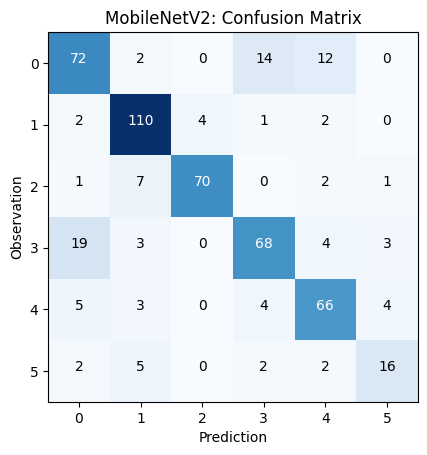

In [24]:
# Compute evaluation given classification results 
def evaluate(Y_hat,Y_truth): 
    print(classification_report(Y_truth,Y_hat,target_names=TARGET_NAMES))
    cm = confusion_matrix(Y_truth, Y_hat)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.title("MobileNetV2: Confusion Matrix")
    plt.xlabel("Prediction")
    plt.ylabel("Observation")
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

evaluate([np.argmax(r) for r in res],test_Y)

From the report and the confusion matrix, we observe a very effective accuracy of 79%. Very few images were misclassified compared to the SIFT descriptor KNN approach. The MobileNetV2 transfer learning approach learned the wild variation in the *trash* class, and admirably correctly classified a significant number of images. Interestingly, the vast majority of misclassification occurred between glass and both metal and plastic. This is an interesting occurrence since perhaps even humans can make the mistake of misclassifying these classes. Perhaps transparent plastic might have been classified as glass, and slightly tinted glass might have done the opposite. This hypothesis could extend to metals as well. 